# Comparing Canadian Living Wages - Final Report

### STAT 201 2021W2 - Group 5

By Michael Guo, Joshua Liu, Samuel Leung

## Introduction

Parents wish for flourishing financial futures for their children, but many worry for the upcoming generations' difficulties in achieving independence (Cariaga, 2021). While financial independence is challenging to quantify, many contributing factors include income and cost of living (Xiao, Chatterjee, & Kim, 2014; Lee & Mortimer, 2009). This analysis seeks to answer the question, "Is a significant change in financial independence hardship for Canadian workers between the years 1990 and 2021?". The minimum weekly wage (numerical variable `min_wage`) represents the income factor of financial independence while the average weekly rent of a one-bedroom apartment (numerical variable `rent`) represents the cost of living.

The data is obtained from two separate datasets published by the Government of Canada that describe the average rent along with the minimum wage in Canadian cities with population greater than 10000. These datasets provide reliable data as the data collection process and quality assurance were managed under the Canadian government. These two datasets were modified to provide two datasets with the average rent of a one-bedroom apartment and minimum wage for the years 1990 and 2021. 

The response variable is the mean of the ratio of minimum wage and rent (labeled `wage_rent_ratio`) of 1990 and 2021 in Canadian cities. Using minimum wage and average rent as the ratio quantities is reasonable, as being able to afford personal housing is a common measure for independence, and minimum wage is a way to quantify earning power. The standard deviation of ratios will also be useful since it provides a comprehensive spread of the differences in non-outlier city data.

## Methods and Results

Loading Required Packages:

In [1]:
install.packages("infer")
install.packages("tidyverse")
library(broom)
library(cowplot)
library(infer)
library(tidyverse)

Installing package into ‘/home/jupyter/R/x86_64-pc-linux-gnu-library/4.1’
(as ‘lib’ is unspecified)

Installing package into ‘/home/jupyter/R/x86_64-pc-linux-gnu-library/4.1’
(as ‘lib’ is unspecified)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



Reading in Data from the Web:

In [2]:
rentwage1990 <- read.csv('https://raw.githubusercontent.com/Guo-Michael/stat_201_project/main/rentwage1990.csv')
rentwage2021 <- read.csv('https://raw.githubusercontent.com/Guo-Michael/stat_201_project/main/rentwage2021.csv')

Cleaning and Wrangling Data:

In [15]:
# Selecting Relevant Features from the Datasets
# Changing Hourly Wage to Weekly Wage, and Monthly Rent to Weekly Rent
rentwage1990filtered <- rentwage1990 %>%
    select(year, city, province, min_wage, rent) %>%
    mutate(min_wage = min_wage * 35) %>%
    mutate(rent = rent * 12 / 52)
rentwage2021filtered <- rentwage2021 %>%
    select(year, city, province, min_wage, rent) %>%
    mutate(min_wage = min_wage * 35) %>%
    mutate(rent = rent * 12 / 52)

# Merging Both Datasets
rentwage_bothyears <- bind_rows(rentwage1990filtered, rentwage2021filtered)

# Checking for Data Inconsistency Over the Years
# If data for a city only appears for one year and not the other,
# the data is incomplete, and therefore will need to be removed
# before analysis.

# Checking for cities that appear in both years
double_cities <- rentwage_bothyears %>%
    group_by(city) %>%
    summarize(n = n()) %>%
    ungroup() %>%
    filter(n == 2) %>%
    pull(city)

# Filtering away cities that do not appear in both years
rentwage_clean <- rentwage_bothyears %>%
    filter(city %in% double_cities) %>%
    select(-province) %>%
# Constructing Wage-Rent Ratio for both years
    mutate(wage_rent_ratio = rent/min_wage) %>%
    select(-min_wage, -rent) %>%
# Wrangling Data to show years as data features, not as a variable
    mutate(year = ifelse(year == 1990, "year1990", "year2021")) %>%
    pivot_wider(names_from = year, values_from = wage_rent_ratio) %>%
# Differencing Ratios
    mutate(ratio_diff = year2021-year1990)

### Exploratory Visualization:

Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


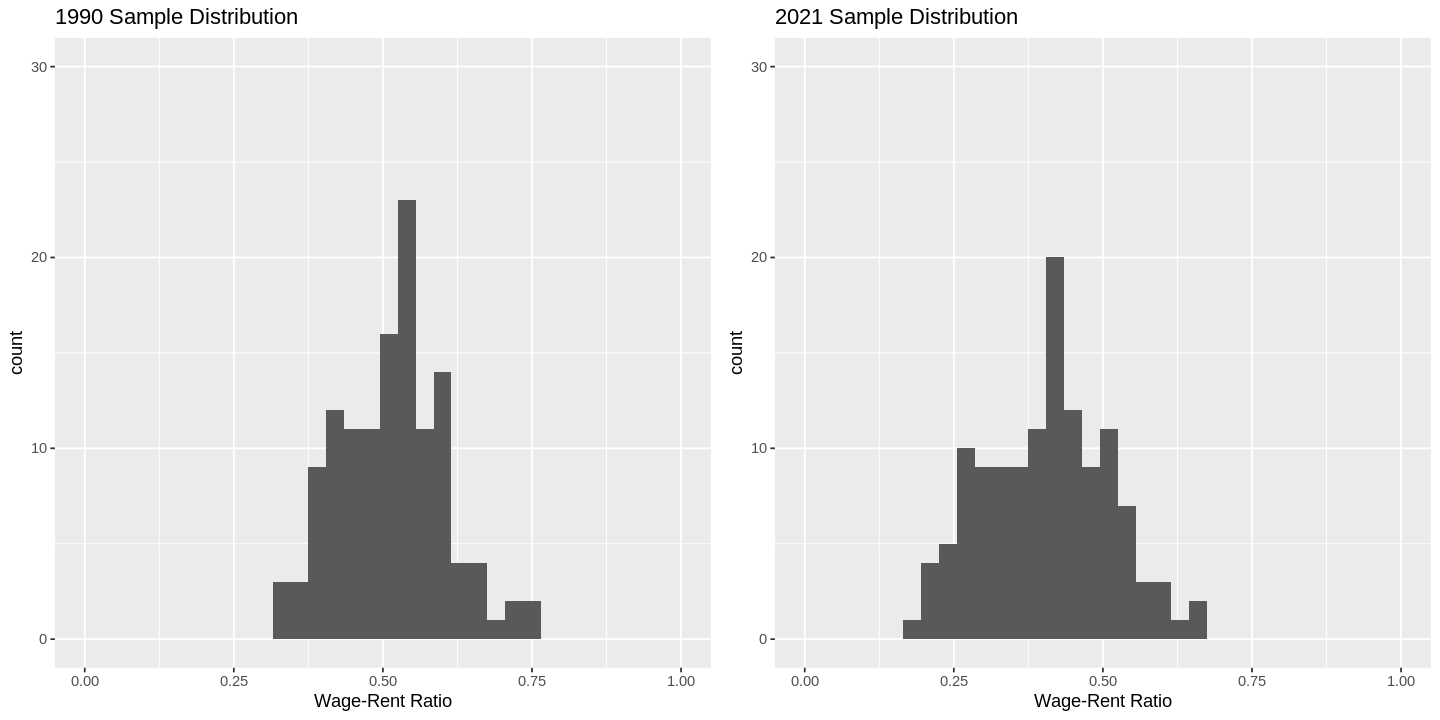

In [4]:
# Visualizaing 2021 Wage-Rent Ratio via Histogram
sample_dist_2021 <- rentwage_clean %>%
    ggplot(aes(x = year2021)) +
    geom_histogram(binwidth = 0.03) +
    ggtitle("2021 Sample Distribution") +
    xlab("Wage-Rent Ratio") +
    xlim(0, 1) +
    ylim(0, 30) 

# Visualizaing 1990 Wage-Rent Ratio via Histogram
sample_dist_1990 <- rentwage_clean %>%
    ggplot(aes(x = year1990)) +
    geom_histogram(binwidth = 0.03) +
    ggtitle("1990 Sample Distribution") +
    xlab("Wage-Rent Ratio") +
    xlim(0, 1) +
    ylim(0, 30)

# Displaying Plots Side by Side
options(repr.plot.width = 12, repr.plot.height = 6)
plots <- plot_grid(sample_dist_1990, sample_dist_2021)
plots

*Figure 1: Sample Distribution of Wage-Rent Ratios from 1990 and 2021*

In [5]:
wage_rent_ratio_diff_estimates <- rentwage_clean %>%
    summarize(mean_ratio_diff = mean(ratio_diff),
              sd_ratio_diff = sd(ratio_diff))
wage_rent_ratio_diff_estimates

mean_ratio_diff,sd_ratio_diff
<dbl>,<dbl>
-0.1081855,0.06628746


*Figure 2: Parameter Estimates for Wage-Rent Ratio Difference Between 1990 and 2021*

From Figures 1 and 2, we see that, though there is an apparent difference between the ratios of 1990 and 2021, more analysis may need to be conducted to conclusively determine a significant difference between the two years. Without deeper inferential analysis, the significance of the ratio difference estimates is inconclusive.

Creating Boxplots of the ratios between 1990 and 2021:

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


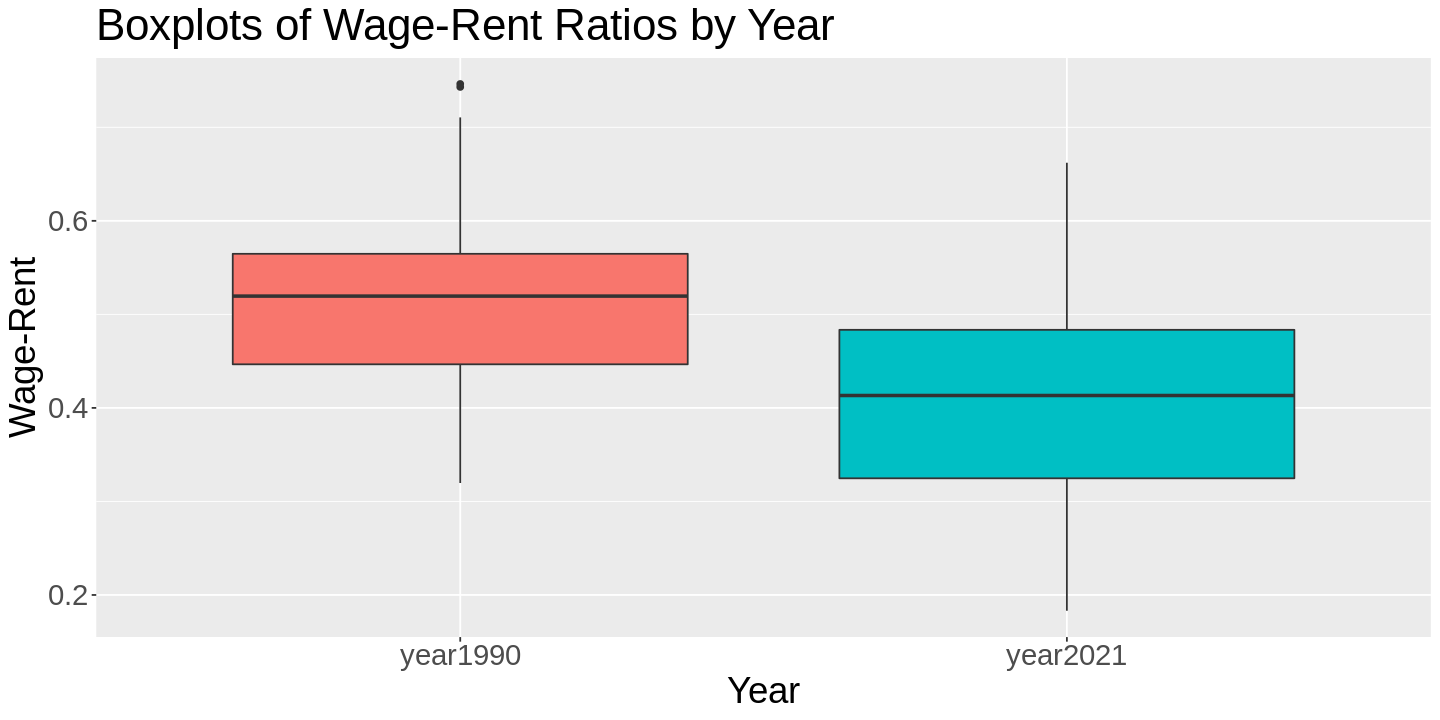

In [6]:
# Preparing Data for Boxplot Visualization Implementation
bp_df <- pivot_longer(rentwage_clean, 
                     cols=year1990:year2021,
                     names_to="year",
                     values_to="wage_ratio")

# Visualizaing Boxplots
boxplots <- bp_df %>%
    ggplot() +
    geom_boxplot(aes(year, wage_ratio, fill=year)) +
    theme(text = element_text(size = 22)) +
    ggtitle("Boxplots of Wage-Rent Ratios by Year") + 
    xlab("Year") + 
    ylab("Wage-Rent") + 
    guides(fill = FALSE)
boxplots

*Figure 3: Boxplot of distribution of Wage-Rent Ratios for years 1990 and 2021*

From the boxplots, we see that the wage-rent ratios in 1990 seem to be higher on average than the wage-rent ratios in 2021; this will be further investigated in the two inferential analysis methods below.

### Asymptotics

We investigate further through a paired one-sample t-test, to determine the significance in the observed difference between the ratios. We avoid a two-sample t-test, since each 1990 observation has a corresponding observation in 2021 of the same city, meaning the two are not independent of each other. We instead use the difference in wage-rent ratios for each city, as we reasonably assume that data between cities are independent of each other.

To begin, we check for normality of the data using a histogram:

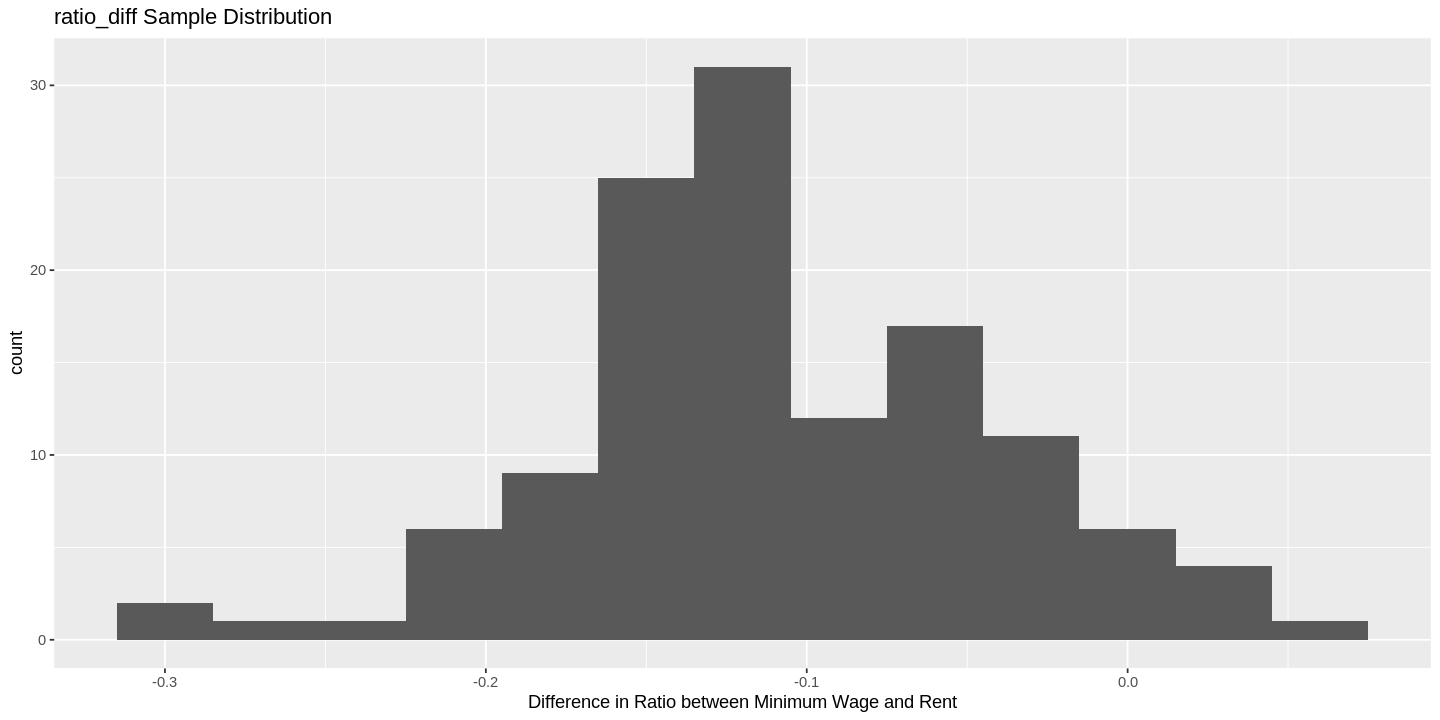

In [7]:
# visualizing the distribution of ratio_diff
ratio_diff_dist <- rentwage_clean %>%
    ggplot(aes(x = ratio_diff)) +
    geom_histogram(binwidth = 0.03) +
    xlab("Difference in Ratio between Minimum Wage and Rent") +
    ggtitle("ratio_diff Sample Distribution")
ratio_diff_dist

*Figure 4: Histogram of wage-rent ratios*

From the histogram above, The normality of the data can be reasonably assumed. We procede through the following steps:

1. Conduct a paired one-sample t-test
2. Using the resulting p-value to make a conclusion to reject or not reject the null hypothesis
3. Interpret the output to obtain a 95% confidence interval

For the paired one-sample t-test, our null hypothesis is "There is no difference in the average wage-rent ratios of 1990 and 2021", namely that the difference of true mean wage ratios is zero. The alternative hypothesis is "There is a difference in the average wage-rent ratios of 1990 and 2021", namely that the difference of true mean wage ratios is non-zero. We set the significance level of the test to be $\alpha = 0.05$.

In [14]:
tidy(t.test(rentwage_clean$year2021,rentwage_clean$year1990, mu=0, paired=TRUE,conf.level=1-0.05))

estimate,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
-0.1081855,-18.31989,3.297283e-37,125,-0.1198729,-0.09649802,Paired t-test,two.sided


*Figure 5: Results of two-sample T-test*

From our test results, we acquired a p-value of roughly $3.297\times 10^{-37}$. As our p-value is lower than the significance level ($\alpha = 0.05$), there is significant evidence that there is a difference between the ratios of 1990 and 2021; therefore, we reject the aforementioned null hypothesis in favor of the alternative hypothesis. We also acquire a 95% confidence interval from the test, which is $[-0.1198729, -0.09649802]$. This confidence interval tells us that if we repeat this test many times, we expect the estimate of the difference of wage-rent ratio means to be within the range of $[-0.1198729, -0.09649802]$ 95% of the time. Since the value 0 is not included in this confidence interval, the results suggest that there is a significant difference between the 1990 and 2021 ratios, which agree with the hypothesis test results.

### Bootstrapping

We continue our exploration of this problem via bootstrapping. Our test statistic continues to be the difference of mean wage-rent ratios of 1990 and 2021, along with the same null and alternative hypothesis used for the one-sample T-test. Bootstrapping produces a poor estimation of the sampling distribution when the sample size is small. We first check the size of our dataset before continuing: 

In [32]:
length(rentwage_clean$ratio_diff)

[1] 126

The sample size is greater than 30, so we assume that the dataset is of sufficient size. We procede through the following steps:

1. Use bootstrapping to approximate a sampling distribution of the difference of wage-rent ratios (ratio_diff)
2. Use the sampling distribution to construct a 95% confidence interval of the mean of ratio_diff
3. Create the null distribution by shifting the sampling distribution of the mean to have mean = 0
4. Compare the observed mean ratio diff to the null distribution and obtain a p-value
5. Make a conclusion whether to reject or not reject the null hypothesis

In [34]:
# bootstrapping
set.seed(1)

# constructing a 95% confidence interval
bootstrap_ci <- rentwage_clean %>%
    specify(response = ratio_diff) %>%
    generate(reps = 10000, type = "bootstrap") %>%
    calculate(stat = "mean") %>%
    get_ci(level = 0.95, type = "percentile")

# hypothesis test
obs_ratio_diff <- wage_rent_ratio_diff_estimates %>% pull(mean_ratio_diff)

bootstrap_null_ratio_diff <- rentwage_clean %>%
    specify(response = ratio_diff) %>%
    hypothesize(null = "point", mu = 0) %>%
    generate(reps = 10000, type = "bootstrap") %>%
    calculate(stat = "mean")

# visualizing the results
bootstrap_result_plot <- bootstrap_null_ratio_diff %>%
    visualize() +
    shade_p_value(obs_stat = obs_ratio_diff, direction = "both") +
    xlab("Mean")

# obtaining the results 
bootstrap_p_value <- bootstrap_null_ratio_diff %>%
    get_p_value(obs_stat = obs_ratio_diff, direction = "both")

Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”


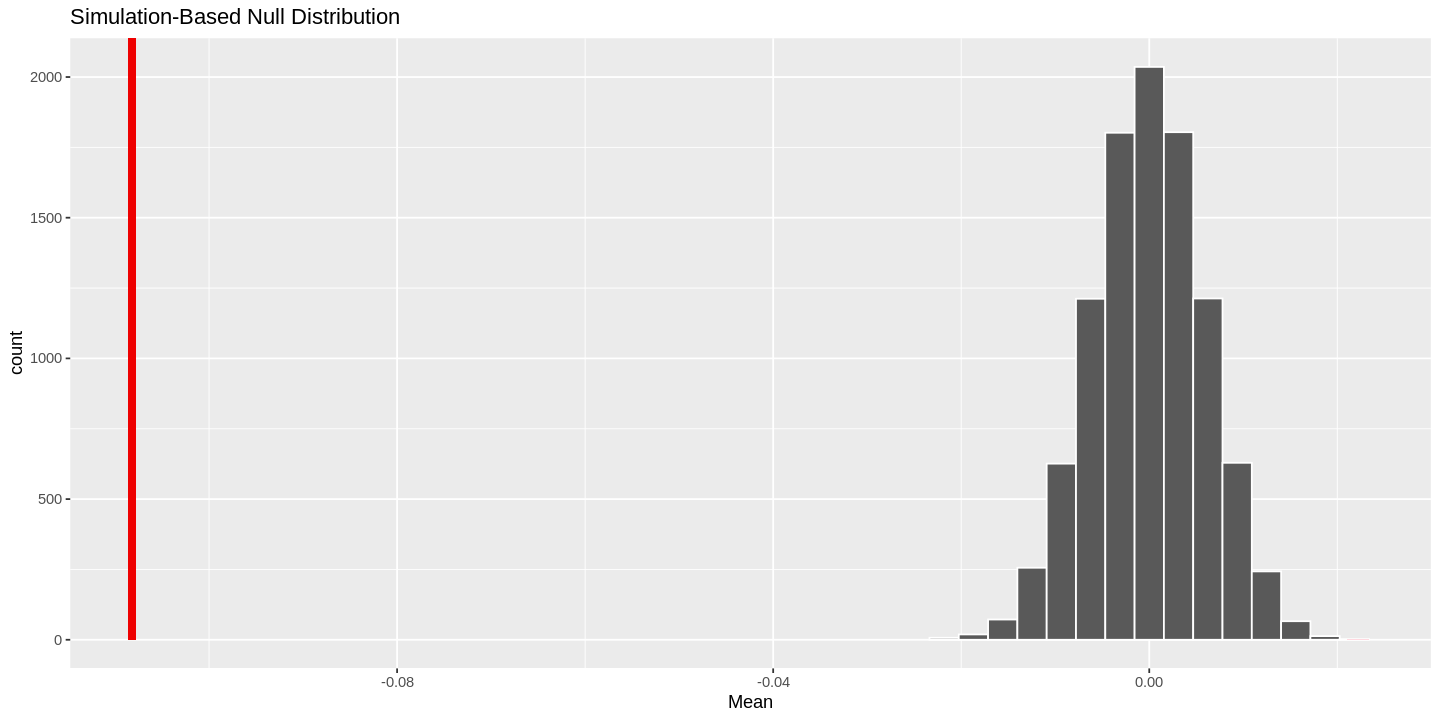

In [35]:
bootstrap_result_plot

*Figure 6: Histogram of null distribution and the observed difference in wage-rent ratio means*

In [42]:
tibble(lower_ci=bootstrap_ci$lower_ci, upper_ci=bootstrap_ci$upper_ci, p_value=bootstrap_p_value$p_value)
# bootstrap_ci 
# bootstrap_p_value

lower_ci,upper_ci,p_value
<dbl>,<dbl>,<dbl>
-0.1195498,-0.09675232,0


*Figure 7: table listing the 95% confidence interval and observed p-value*

From our hypothesis test using bootstrapping, we acquire a p-value of 0. We interpret that this value is a rounded estimate of a very small value from the code's computations using floating point numbers, since a true p-value of 0 cannot be obtained by any finite observed value due to the tails of the distribution spanning to positive and negative infinity. Given that our p-value is less than the significance level of $5\%$, we conclude once again that we favor the alternative hypothesis over the null. The $95\%$ confidence interval from this test is $[-0.1195498, -0.09675232]$, which is extremely similar to the confidence interval we observe from the t-test above. This confidence interval reassures that repeating this test many times will give us an estimate of the difference of mean wage-rent ratios contained in this interval 95% of the time. 

From the tests above, we see that both bootstrapping and asymptotic methods resulted in a rejection of the null hypothesis. Furthermore, the confidence intervals produced were very similar to one another. From the confidence intervals produced, it seems that both bootstrapping and asymptotic methods led to estimating very similar sampling distributions. From this, it is expected that both tests would give similar results, and so we conclude that both tests work equally well in this situation, and that neither test seems to be more appropriate to use than the other. 

## Discussion

From our hypothesis tests, we found that there is a negative difference in average wage-rent ratios between the years 1990 and 2021. In the context of our question, this means that there has been a decrease in financial independence hardship for Canadian workers in 2021 since 1990. This result was not expected, as it contrasts the established motivation of this analysis of how younger generations are experiencing prolonged financial frustration and hardship. However, the implications of these findings may be limited, as minimum rage and the rent of a one-bedroom apartment are only one of many ways to quantify independence and earning power, respectively. While the current data may imply a decrease in hardship, few Canadians may rely on minimum wage or a one-bedroom apartment as permanent living conditions, and therefore the analysis may not be a holistic representation of the socioeconomic changes of the past three decades.

Other quantifiers of independence, such as rent or listings of other residence types, as well as other essential living expenses (such as transportation and food), should be considered in future studies. Other quantifiers of earning power, such as average income, as well as quantifiers for job search and security, should also be considered in future studies, so to include more data from different portions of the population to better represent them in analyses. Furthermore, data from each year can be analysed using time-series analyses in future research, combining the different quantifiers, so to extract more information on year-by-year changes, to better suggest economic and community-related solutions for the security, stability, and growth of future generations.

## References

Cariaga, V. (2021, December 8). Over 60% of millennials and gen Z are 'constantly stressed' about money, survey finds. GOBankingRates. Retrieved March 5, 2022, from https://www.gobankingrates.com/money/financial-planning/over-60-of-millennials-and-gen-z-are-constantly-stressed-about-money-survey-finds/

Government of Canada. (2022, February 21). Average rents for areas with a population of 10,000 and over - dataset. Open Government Portal. Retrieved March 5, 2022, from https://open.canada.ca/data/en/dataset/1146388b-a150-4e70-98ec-eb40cb9083c8/resource/2be23210-9dd2-4511-840e-c467e0645827 

Government of Canada. (2016, December 6). Hourly minimum wages in Canada for adult workers. Hourly Minimum Wages in CANADA for Adult Workers - Canada.ca. Retrieved March 5, 2022, from http://srv116.services.gc.ca/dimt-wid/sm-mw/rpt2.aspx 

Lee, J. C., & Mortimer, J. T. (2009). Family Socialization, Economic Self-Efficacy, and the Attainment of Financial Independence in Early Adulthood. *Longitudinal and life course studies : international journal, 1*(1), 45–62.

Xiao, J. J., Chatterjee, S., &amp; Kim, J. (2014). Factors associated with financial independence of Young Adults. *International Journal of Consumer Studies, 38*(4), 394–403. https://doi.org/10.1111/ijcs.12106 
